In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Creating multiple dataframe with different "look back" periods
# The periods are 1 day, 3 days. 7 days. 15 days. 30 days and 60 days
# The look back periods should be in the form of a list
# For example, if the look back period is 3, then the dataframe should have 3 columns
# Date, Close, [Close(t-1), Close(t-2), Close(t-3)]

def create_look_back_arrays(df, window_size = 1):
    df = df.drop(columns = ['Date'])
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i+window_size])
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [3]:
df = pd.read_csv('../Data/ethereum_data.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1660,2022-05-27,1802.543823,1814.656494,1721.264771,1724.922852,1724.922852,25470760032
1661,2022-05-28,1724.635986,1757.941772,1724.635986,1757.941772,1757.941772,23214777872
1662,2022-05-29,1792.184448,1818.776611,1765.937378,1812.031006,1812.031006,10642556101
1663,2022-05-30,1811.885986,2005.210815,1804.456055,1996.441284,1996.441284,19580808705


In [5]:
df = df[['Date', 'Close']]

In [6]:
df

,Date,Close
0,2017-11-09,320.884003
1,2017-11-10,299.252991
2,2017-11-11,314.681000
3,2017-11-12,307.907990
4,2017-11-13,316.716003
...,...,...
1660,2022-05-27,1724.922852
1661,2022-05-28,1757.941772
1662,2022-05-29,1812.031006
1663,2022-05-30,1996.441284


In [7]:
# Scale the values in the Close column
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

/var/folders/76/w363ly_90ln6pf3txlrc64bw0000gn/T/ipykernel_52646/3875126601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [8]:
df

,Date,Close
0,2017-11-09,0.050040
1,2017-11-10,0.045464
2,2017-11-11,0.048727
3,2017-11-12,0.047295
4,2017-11-13,0.049158
...,...,...
1660,2022-05-27,0.347016
1661,2022-05-28,0.354000
1662,2022-05-29,0.365441
1663,2022-05-30,0.404446


In [9]:
x_1, y_1 = create_look_back_arrays(df, 1)
x_3, y_3 = create_look_back_arrays(df, 3)
x_7, y_7 = create_look_back_arrays(df, 7)
x_15, y_15 = create_look_back_arrays(df, 15)
x_30, y_30 = create_look_back_arrays(df, 30)
x_60, y_60 = create_look_back_arrays(df, 60)

# 1 Day look back window

In [10]:
x_1.shape, y_1.shape

((1664, 1, 1), (1664, 1))

In [11]:
X_1_train, y_1_train = x_1[:1300], y_1[:1300]
X_1_val, y_1_val = x_1[1300:1500], y_1[1300:1500]
X_1_test, y_1_test = x_1[1500:], y_1[1500:]
X_1_train.shape, y_1_train.shape, X_1_val.shape, y_1_val.shape, X_1_test.shape, y_1_test.shape

((1300, 1, 1), (1300, 1), (200, 1, 1), (200, 1), (164, 1, 1), (164, 1))

In [12]:
model_1 = Sequential()
model_1.add(InputLayer(input_shape = (1, 1)))
model_1.add(GRU(64))
model_1.add(Dense(8, activation = 'relu'))
model_1.add(Dense(1, activation = 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('models/gru_1.h5', save_best_only = True)
model_1.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [14]:
model_1.fit(X_1_train, y_1_train, epochs = 200, validation_data = (X_1_val, y_1_val), callbacks = [cp])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0218 - root_mean_squared_error: 0.1477 - mean_absolute_error: 0.0779 - val_loss: 0.3727 - val_root_mean_squared_error: 0.6105 - val_mean_absolute_error: 0.5870
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - mean_absolute_error: 0.0646 - val_loss: 0.3117 - val_root_mean_squared_error: 0.5583 - val_mean_absolute_error: 0.5352
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - mean_absolute_error: 0.0629 - val_loss: 0.2699 - val_root_mean_squared_error: 0.5195 - val_mean_absolute_error: 0.4964
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0116 - root_mean_squared_error: 0.1075 - mean_absolute_error: 0.0622 - val_loss: 0.2380 - val_root_mean_squared_error: 0.4878 - val_mean_absolute_error: 0.4650
Epoch 5/200
 1/41 [..............................] - ETA: 0s

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 1ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - mean_absolute_error: 0.0612 - val_loss: 0.2121 - val_root_mean_squared_error: 0.4605 - val_mean_absolute_error: 0.4380
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - mean_absolute_error: 0.0585 - val_loss: 0.1921 - val_root_mean_squared_error: 0.4382 - val_mean_absolute_error: 0.4163
Epoch 7/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - mean_absolute_error: 0.0567 - val_loss: 0.1702 - val_root_mean_squared_error: 0.4126 - val_mean_absolute_error: 0.3912
Epoch 8/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - mean_absolute_error: 0.0527 - val_loss: 0.1522 - val_root_mean_squared_error: 0.3901 - val_mean_absolute_error: 0.3691
Epoch 9/200
41/41 [==============================] - 0s 1ms/step - loss:

In [15]:
model_1 = load_model('models/gru_1.h5')

In [16]:
test_1_predictions = model_1.predict(X_1_test)
test_results = pd.DataFrame({'Actual': y_1_test.flatten(), 'Predicted': test_1_predictions.flatten()})
test_results

6/6 [==============================] - 0s 563us/step


,Actual,Predicted
0,0.811858,0.796195
1,0.814238,0.789905
2,0.832516,0.791754
3,0.824444,0.805961
4,0.851078,0.799687
...,...,...
159,0.347016,0.367377
160,0.354000,0.350364
161,0.365441,0.357475
162,0.404446,0.369126


In [17]:
# Creating a dataframe with the actual and predicted values without the scaling 
test_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1501:].flatten(), 'Predicted': scaler.inverse_transform(test_1_predictions).flatten()})
test_results_unscaled

,Actual,Predicted
0,3922.592529,3848.544189
1,3933.844482,3818.803955
2,4020.260010,3827.547852
3,3982.099609,3894.711914
4,4108.015625,3865.051270
...,...,...
159,1724.922852,1821.185791
160,1757.941772,1740.751709
161,1812.031006,1774.369263
162,1996.441284,1829.454224


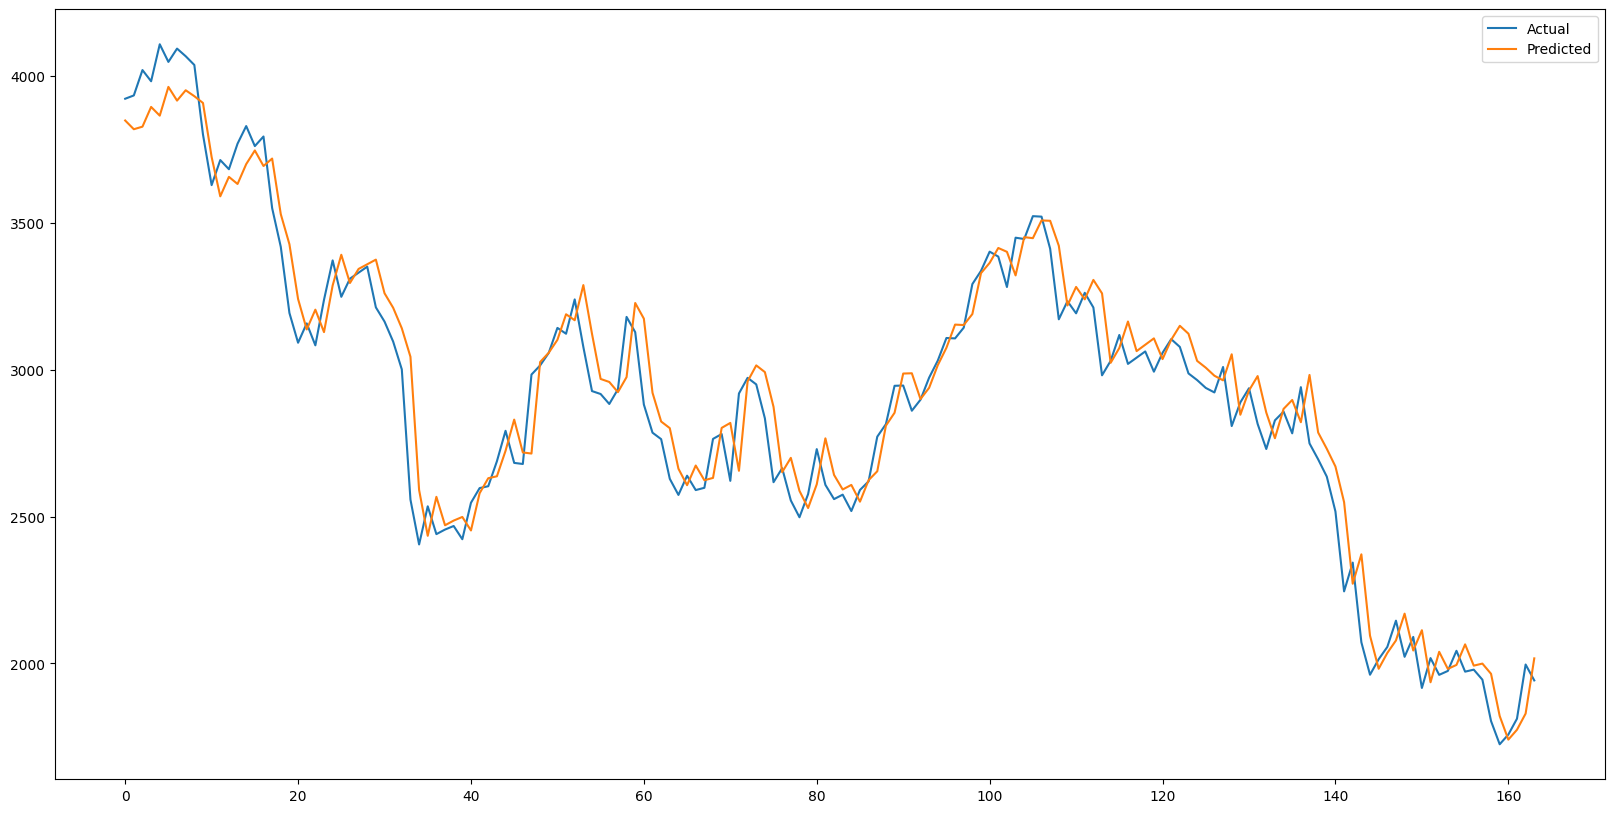

In [18]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [19]:
# Calculating the RMSE and MAE
rmse = np.sqrt(np.mean((test_results_unscaled['Actual'] - test_results_unscaled['Predicted'])**2))
mae = np.mean(np.abs(test_results_unscaled['Actual'] - test_results_unscaled['Predicted']))
rmse, mae

(122.96180291475227, 95.13125089319743)

# 3 Day Look Back Window

In [20]:
x_3.shape, y_3.shape

((1662, 3, 1), (1662, 1))

In [21]:
X_3_train, y_3_train = x_3[:1300], y_3[:1300]
X_3_val, y_3_val = x_3[1300:1500], y_3[1300:1500]
X_3_test, y_3_test = x_3[1500:], y_3[1500:]
X_3_train.shape, y_3_train.shape, X_3_val.shape, y_3_val.shape, X_3_test.shape, y_3_test.shape

((1300, 3, 1), (1300, 1), (200, 3, 1), (200, 1), (162, 3, 1), (162, 1))

In [22]:
model_3 = Sequential()
model_3.add(InputLayer(input_shape = (3, 1)))
model_3.add(GRU(64))
model_3.add(Dense(8, activation = 'relu'))
model_3.add(Dense(1, activation = 'linear'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
cp3 = ModelCheckpoint('models/gru_3.h5', save_best_only = True)
model_3.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [24]:
model_3.fit(X_3_train, y_3_train, epochs = 200, validation_data = (X_3_val, y_3_val), callbacks = [cp3])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - mean_absolute_error: 0.0774 - val_loss: 0.3569 - val_root_mean_squared_error: 0.5974 - val_mean_absolute_error: 0.5725
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - mean_absolute_error: 0.0599 - val_loss: 0.2219 - val_root_mean_squared_error: 0.4710 - val_mean_absolute_error: 0.4469
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0080 - root_mean_squared_error: 0.0897 - mean_absolute_error: 0.0546 - val_loss: 0.1505 - val_root_mean_squared_error: 0.3880 - val_mean_absolute_error: 0.3662
Epoch 4/200
 1/41 [..............................] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - mean_absolute_error: 0.0568

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 2ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - mean_absolute_error: 0.0481 - val_loss: 0.1019 - val_root_mean_squared_error: 0.3192 - val_mean_absolute_error: 0.3000
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - mean_absolute_error: 0.0397 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2571 - val_mean_absolute_error: 0.2403
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0312 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1986 - val_mean_absolute_error: 0.1829
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0239 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1554 - val_mean_absolute_error: 0.1409
Epoch 8/200
41/41 [==============================] - 0s 2ms/step - loss:

In [25]:
model_3 = load_model('models/gru_3.h5')

In [26]:
test_3_predictions = model_3.predict(X_3_test)
test_3_results = pd.DataFrame({'Actual': y_3_test.flatten(), 'Predicted': test_3_predictions.flatten()})
test_3_results

6/6 [==============================] - 0s 652us/step


,Actual,Predicted
0,0.832516,0.806970
1,0.824444,0.814714
2,0.851078,0.816433
3,0.838380,0.829315
4,0.847961,0.829549
...,...,...
157,0.347016,0.385831
158,0.354000,0.366256
159,0.365441,0.360013
160,0.404446,0.365685


In [27]:
# Creating a dataframe with the actual and predicted values without the scaling
test_3_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1503:].flatten(), 'Predicted': scaler.inverse_transform(test_3_predictions).flatten()})

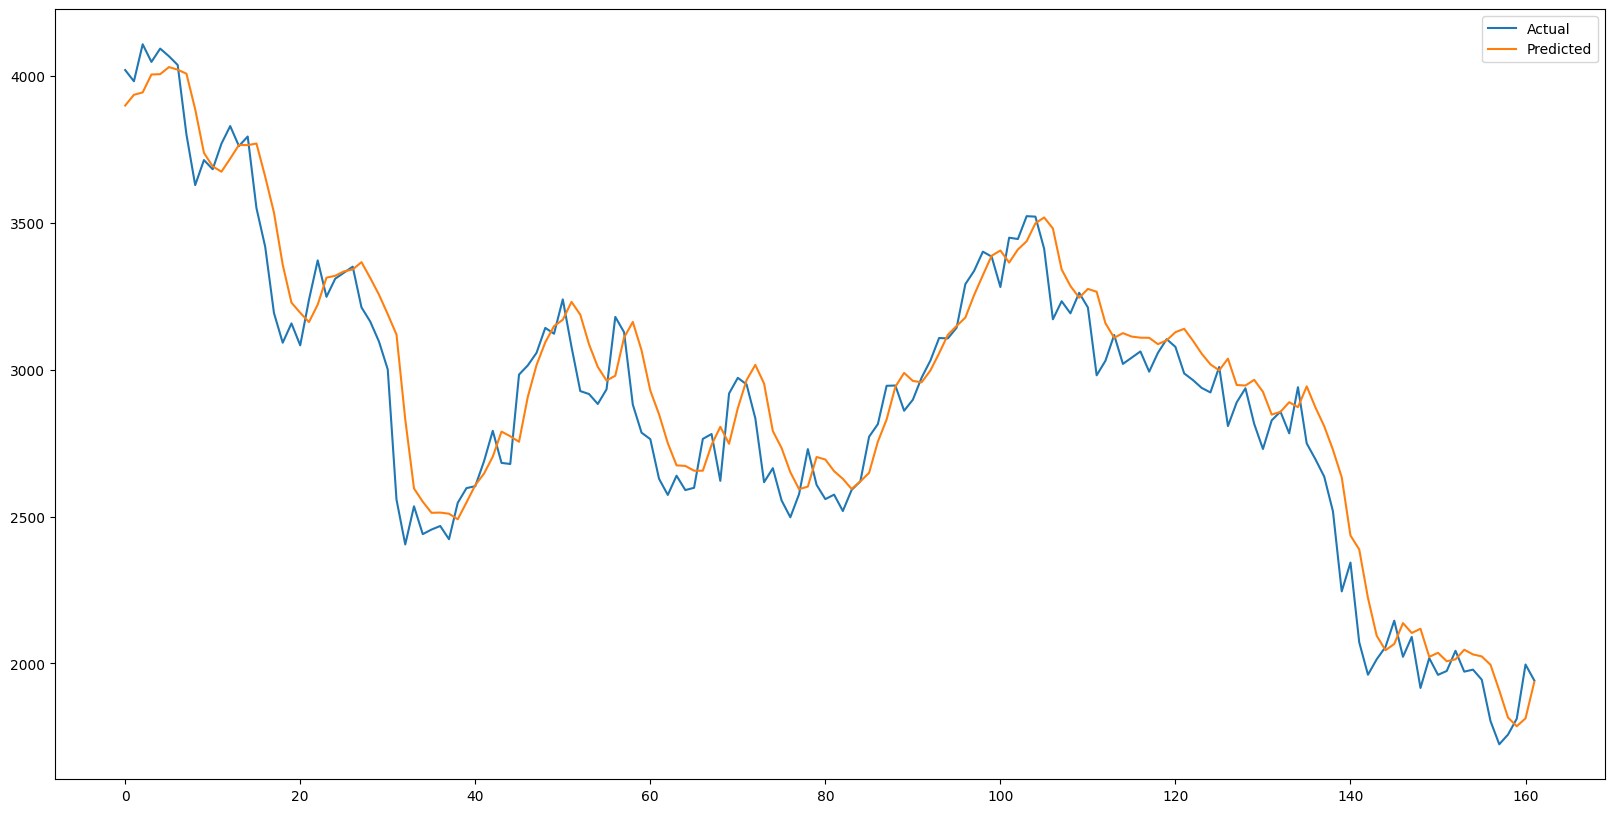

In [28]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_3_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_3_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [29]:
# Calculating the RMSE and MAE
rmse_3 = np.sqrt(np.mean((test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted'])**2))
mae_3 = np.mean(np.abs(test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted']))
rmse_3, mae_3

(143.4295184832451, 108.84264835310573)

# 7 Day Look Back Window

In [30]:
x_7.shape, y_7.shape

((1658, 7, 1), (1658, 1))

In [31]:
X_7_train, y_7_train = x_7[:1300], y_7[:1300]
X_7_val, y_7_val = x_7[1300:1500], y_7[1300:1500]
X_7_test, y_7_test = x_7[1500:], y_7[1500:]
X_7_train.shape, y_7_train.shape, X_7_val.shape, y_7_val.shape, X_7_test.shape, y_7_test.shape

((1300, 7, 1), (1300, 1), (200, 7, 1), (200, 1), (158, 7, 1), (158, 1))

In [32]:
model_7 = Sequential()
model_7.add(InputLayer(input_shape = (7, 1)))
model_7.add(GRU(64))
model_7.add(Dense(8, activation = 'relu'))
model_7.add(Dense(1, activation = 'linear'))

model_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
cp7 = ModelCheckpoint('models/gru_7.h5', save_best_only = True)
model_7.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [34]:
model_7.fit(X_7_train, y_7_train, epochs = 200, validation_data = (X_7_val, y_7_val), callbacks = [cp7])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0252 - root_mean_squared_error: 0.1586 - mean_absolute_error: 0.0804 - val_loss: 0.3564 - val_root_mean_squared_error: 0.5970 - val_mean_absolute_error: 0.5724
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - mean_absolute_error: 0.0615 - val_loss: 0.2303 - val_root_mean_squared_error: 0.4799 - val_mean_absolute_error: 0.4573
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0086 - root_mean_squared_error: 0.0929 - mean_absolute_error: 0.0534 - val_loss: 0.1579 - val_root_mean_squared_error: 0.3974 - val_mean_absolute_error: 0.3760
Epoch 4/200
 1/41 [..............................] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1014 - mean_absolute_error: 0.0581

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 2ms/step - loss: 0.0056 - root_mean_squared_error: 0.0745 - mean_absolute_error: 0.0450 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3147 - val_mean_absolute_error: 0.2945
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - mean_absolute_error: 0.0347 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2381 - val_mean_absolute_error: 0.2190
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - mean_absolute_error: 0.0244 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1739 - val_mean_absolute_error: 0.1554
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 8.3177e-04 - root_mean_squared_error: 0.0288 - mean_absolute_error: 0.0161 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174 - val_mean_absolute_error: 0.0997
Epoch 8/200
41/41 [==============================] - 0s 2ms/step - l

In [35]:
model_7 = load_model('models/gru_7.h5')

In [36]:
test_7_predictions = model_7.predict(X_7_test)
test_7_results = pd.DataFrame({'Actual': y_7_test.flatten(), 'Predicted': test_7_predictions.flatten()})
test_7_results

5/5 [==============================] - 0s 880us/step


,Actual,Predicted
0,0.847961,0.836302
1,0.842472,0.841241
2,0.836173,0.838804
3,0.786116,0.833254
4,0.749659,0.797355
...,...,...
153,0.347016,0.385875
154,0.354000,0.366931
155,0.365441,0.363333
156,0.404446,0.369459


In [37]:
# Creating a dataframe with the actual and predicted values without the scaling
test_7_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1507:].flatten(), 'Predicted': scaler.inverse_transform(test_7_predictions).flatten()})

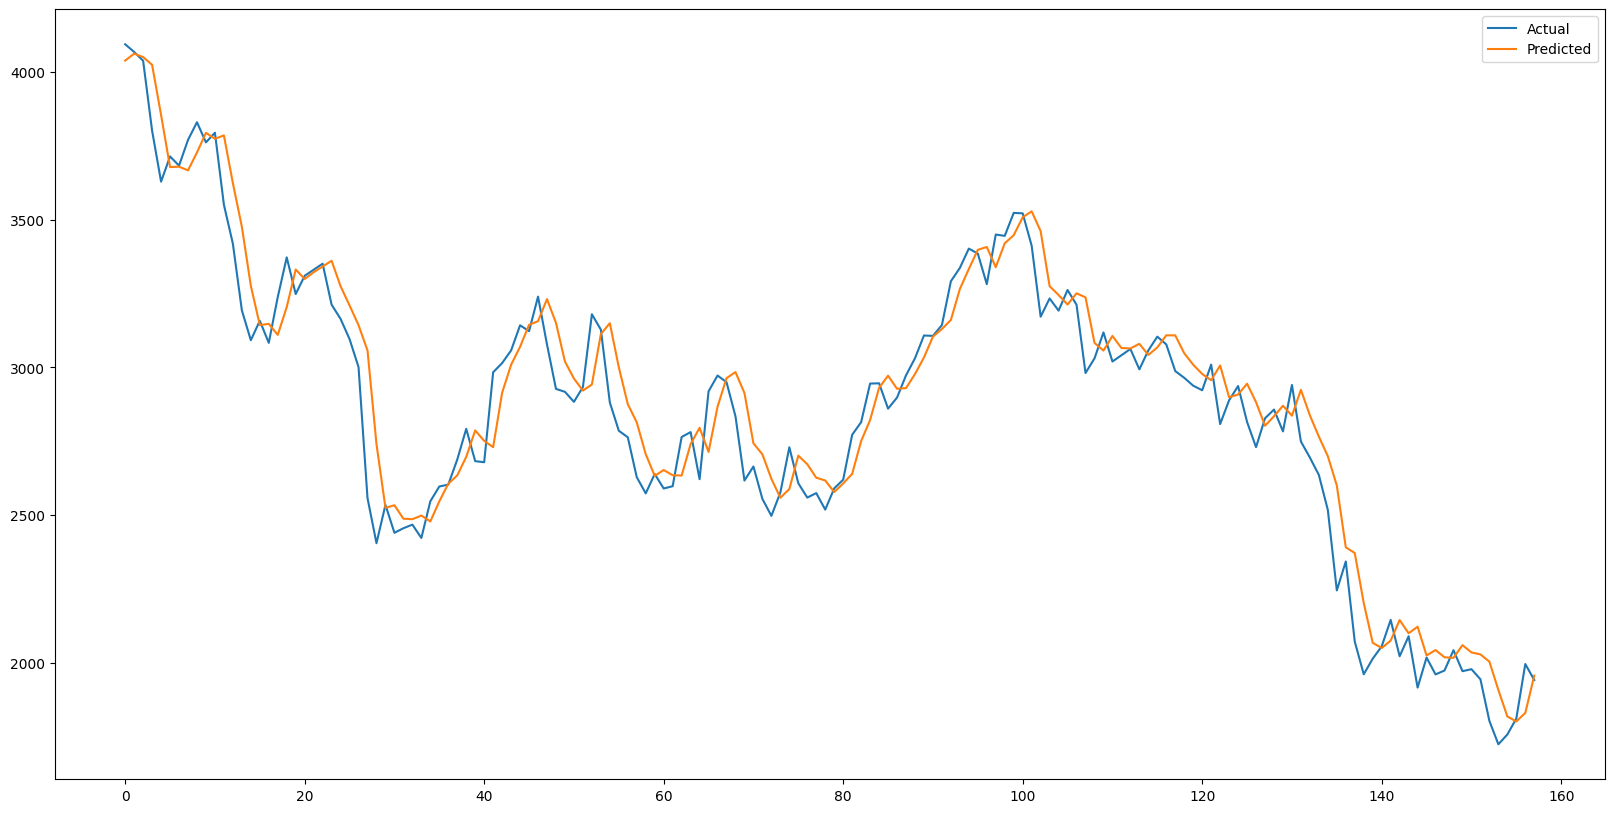

In [38]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_7_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_7_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [39]:
rmse_7 = np.sqrt(np.mean((test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted'])**2))
mae_7 = np.mean(np.abs(test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted']))
rmse_7, mae_7

(129.19439813868695, 97.56360172320018)

# 15 Day Look Back Window

In [40]:
x_15.shape, y_15.shape

((1650, 15, 1), (1650, 1))

In [41]:
X_15_train, y_15_train = x_15[:1300], y_15[:1300]
X_15_val, y_15_val = x_15[1300:1500], y_15[1300:1500]
X_15_test, y_15_test = x_15[1500:], y_15[1500:]
X_15_train.shape, y_15_train.shape, X_15_val.shape, y_15_val.shape, X_15_test.shape, y_15_test.shape

((1300, 15, 1), (1300, 1), (200, 15, 1), (200, 1), (150, 15, 1), (150, 1))

In [42]:
model_15 = Sequential()
model_15.add(InputLayer(input_shape = (15, 1)))
model_15.add(GRU(64))
model_15.add(Dense(8, activation = 'relu'))
model_15.add(Dense(1, activation = 'linear'))

model_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                12864     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
cp15 = ModelCheckpoint('models/gru_15.h5', save_best_only = True)
model_15.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [44]:
model_15.fit(X_15_train, y_15_train, epochs = 200, validation_data = (X_15_val, y_15_val), callbacks = [cp15])

Epoch 1/200
41/41 [==============================] - 1s 7ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652 - mean_absolute_error: 0.0880 - val_loss: 0.4215 - val_root_mean_squared_error: 0.6492 - val_mean_absolute_error: 0.6263
Epoch 2/200
41/41 [==============================] - 0s 4ms/step - loss: 0.0170 - root_mean_squared_error: 0.1306 - mean_absolute_error: 0.0692 - val_loss: 0.2825 - val_root_mean_squared_error: 0.5315 - val_mean_absolute_error: 0.5094
Epoch 3/200
 1/41 [..............................] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0702 - mean_absolute_error: 0.0393

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 4ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - mean_absolute_error: 0.0627 - val_loss: 0.1844 - val_root_mean_squared_error: 0.4295 - val_mean_absolute_error: 0.4087
Epoch 4/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0520 - val_loss: 0.1148 - val_root_mean_squared_error: 0.3389 - val_mean_absolute_error: 0.3198
Epoch 5/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - mean_absolute_error: 0.0296 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238 - val_mean_absolute_error: 0.2042
Epoch 6/200
41/41 [==============================] - 0s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - mean_absolute_error: 0.0163 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257 - val_mean_absolute_error: 0.1085
Epoch 7/200
41/41 [==============================] - 0s 3ms/step - loss:

In [45]:
model_15 = load_model('models/gru_15.h5')

In [46]:
test_15_predictions = model_15.predict(X_15_test)
test_15_results = pd.DataFrame({'Actual': y_15_test.flatten(), 'Predicted': test_15_predictions.flatten()})
test_15_results

5/5 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.792181,0.765410
1,0.777759,0.782119
2,0.784670,0.776663
3,0.733130,0.779186
4,0.705215,0.740487
...,...,...
145,0.347016,0.380109
146,0.354000,0.359325
147,0.365441,0.356928
148,0.404446,0.365471


In [47]:
# Creating a dataframe with the actual and predicted values without the scaling
test_15_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1515:].flatten(), 'Predicted': scaler.inverse_transform(test_15_predictions).flatten()})

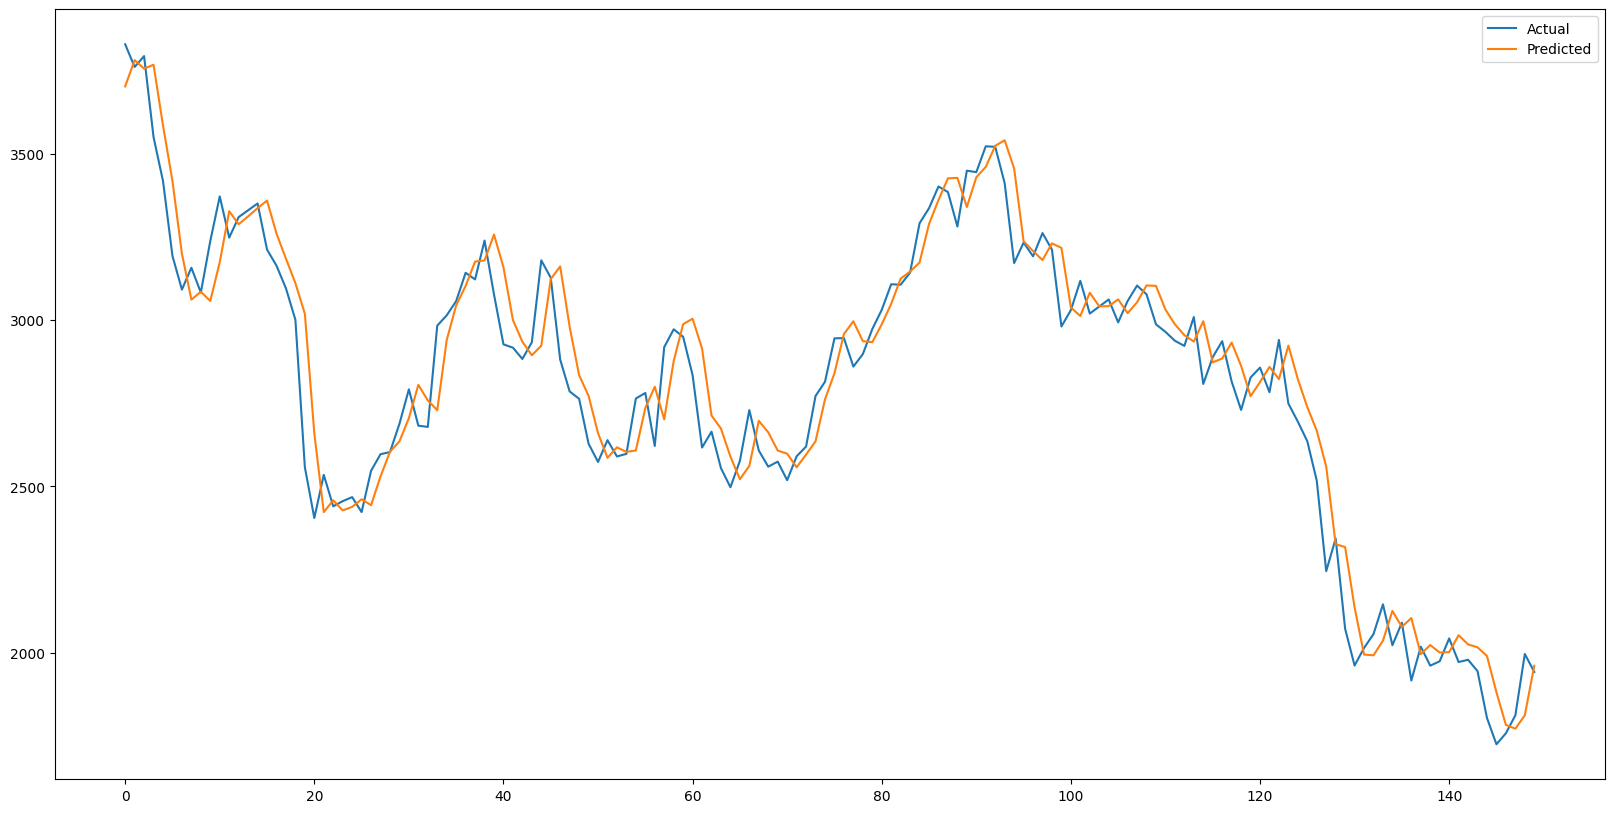

In [48]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_15_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_15_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [49]:
rmse_15 = np.sqrt(np.mean((test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted'])**2))
mae_15 = np.mean(np.abs(test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted']))
rmse_15, mae_15

(121.65118581476423, 92.92902587890627)

# 30 Day Look Back Window

In [50]:
x_30.shape, y_30.shape

((1635, 30, 1), (1635, 1))

In [51]:
X_30_train, y_30_train = x_30[:1300], y_30[:1300]
X_30_val, y_30_val = x_30[1300:1500], y_30[1300:1500]
X_30_test, y_30_test = x_30[1500:], y_30[1500:]
X_30_train.shape, y_30_train.shape, X_30_val.shape, y_30_val.shape, X_30_test.shape, y_30_test.shape

((1300, 30, 1), (1300, 1), (200, 30, 1), (200, 1), (135, 30, 1), (135, 1))

In [52]:
model_30 = Sequential()
model_30.add(InputLayer(input_shape = (30, 1)))
model_30.add(GRU(64))
model_30.add(Dense(8, activation = 'relu'))
model_30.add(Dense(1, activation = 'linear'))

model_30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                12864     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
cp30 = ModelCheckpoint('models/gru_30.h5', save_best_only = True)
model_30.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [54]:
model_30.fit(X_30_train, y_30_train, epochs = 200, validation_data = (X_30_val, y_30_val), callbacks = [cp30])

Epoch 1/200
41/41 [==============================] - 1s 13ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - mean_absolute_error: 0.1016 - val_loss: 0.4961 - val_root_mean_squared_error: 0.7044 - val_mean_absolute_error: 0.6862
Epoch 2/200
31/41 [=====================>........] - ETA: 0s - loss: 0.0250 - root_mean_squared_error: 0.1580 - mean_absolute_error: 0.0816

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 6ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - mean_absolute_error: 0.0826 - val_loss: 0.4093 - val_root_mean_squared_error: 0.6398 - val_mean_absolute_error: 0.6216
Epoch 3/200
41/41 [==============================] - 0s 6ms/step - loss: 0.0174 - root_mean_squared_error: 0.1321 - mean_absolute_error: 0.0702 - val_loss: 0.2817 - val_root_mean_squared_error: 0.5308 - val_mean_absolute_error: 0.5135
Epoch 4/200
41/41 [==============================] - 0s 6ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - mean_absolute_error: 0.0607 - val_loss: 0.1859 - val_root_mean_squared_error: 0.4311 - val_mean_absolute_error: 0.4145
Epoch 5/200
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - mean_absolute_error: 0.0501 - val_loss: 0.1020 - val_root_mean_squared_error: 0.3194 - val_mean_absolute_error: 0.3035
Epoch 6/200
41/41 [==============================] - 0s 6ms/step - loss:

In [55]:
model_30 = load_model('models/gru_30.h5')

In [56]:
test_30_predictions = model_30.predict(X_30_test)
test_30_results = pd.DataFrame({'Actual': y_30_test.flatten(), 'Predicted': test_30_predictions.flatten()})
test_30_results

5/5 [==============================] - 0s 2ms/step


,Actual,Predicted
0,0.661621,0.691274
1,0.651409,0.669873
2,0.636984,0.654171
3,0.616952,0.638822
4,0.523210,0.619518
...,...,...
130,0.347016,0.380765
131,0.354000,0.360412
132,0.365441,0.358611
133,0.404446,0.367290


In [57]:
# Creating a dataframe with the actual and predicted values without the scaling
test_30_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1530:].flatten(), 'Predicted': scaler.inverse_transform(test_30_predictions).flatten()})

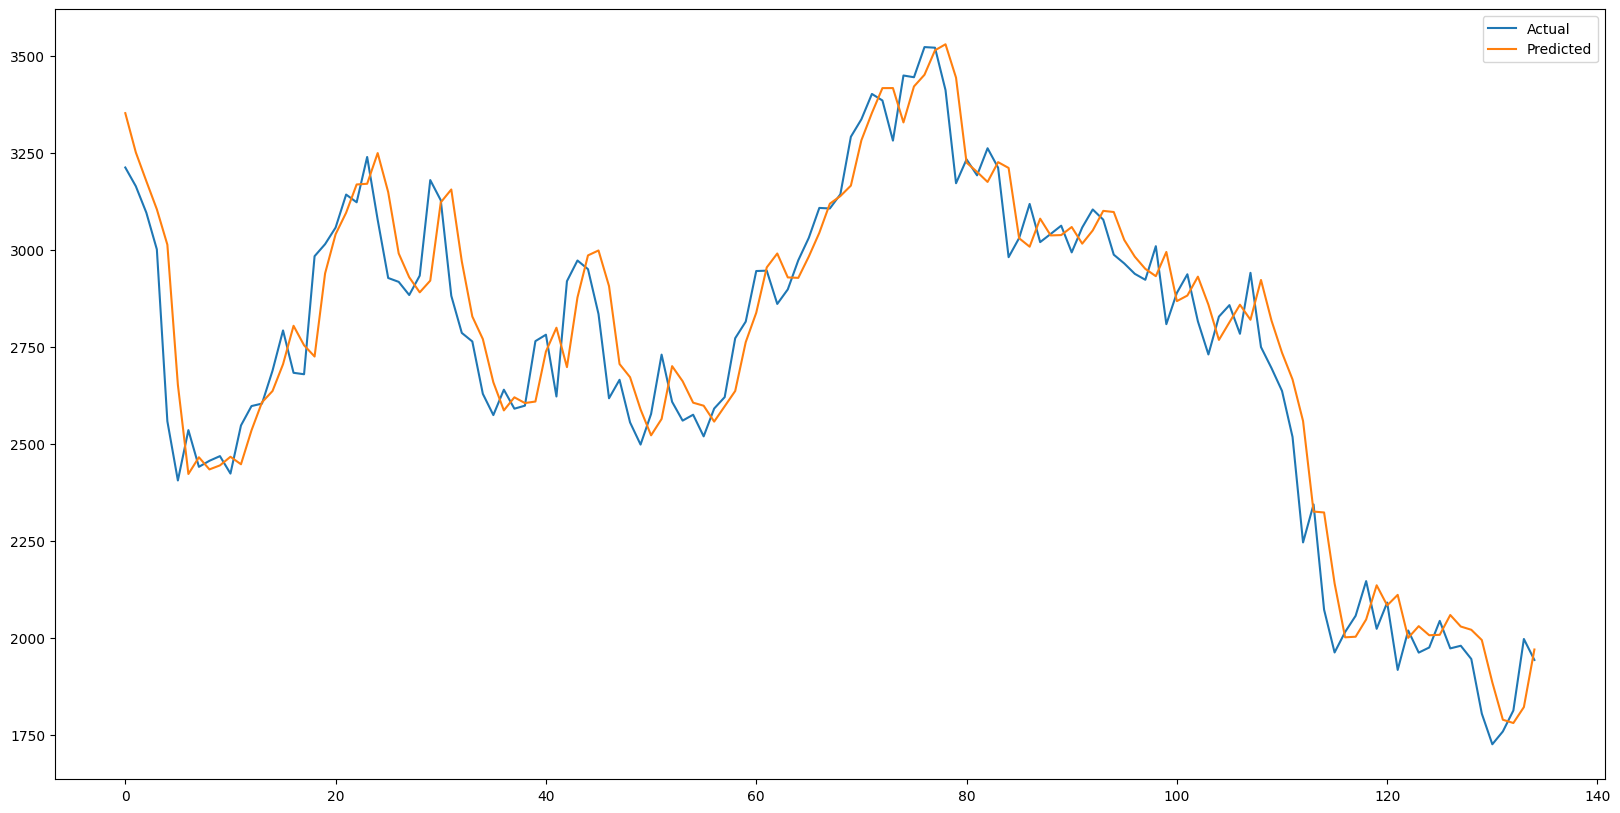

In [58]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_30_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_30_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [59]:
rmse_30 = np.sqrt(np.mean((test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted'])**2))
mae_30 = np.mean(np.abs(test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted']))
rmse_30, mae_30

(119.51717663359325, 91.09995117187502)

# 60 Day Look Back Window

In [60]:
x_60.shape, y_60.shape

((1605, 60, 1), (1605, 1))

In [61]:
X_60_train, y_60_train = x_60[:1300], y_60[:1300]
X_60_val, y_60_val = x_60[1300:1500], y_60[1300:1500]
X_60_test, y_60_test = x_60[1500:], y_60[1500:]
X_60_train.shape, y_60_train.shape, X_60_val.shape, y_60_val.shape, X_60_test.shape, y_60_test.shape

((1300, 60, 1), (1300, 1), (200, 60, 1), (200, 1), (105, 60, 1), (105, 1))

In [62]:
model_60 = Sequential()
model_60.add(InputLayer(input_shape = (60, 1)))
model_60.add(GRU(64))
model_60.add(Dense(8, activation = 'relu'))
model_60.add(Dense(1, activation = 'linear'))

model_60.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
cp60 = ModelCheckpoint('models/gru_60.h5', save_best_only = True)
model_60.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [64]:
model_60.fit(X_60_train, y_60_train, epochs = 200, validation_data = (X_60_val, y_60_val), callbacks = [cp60])

Epoch 1/200
41/41 [==============================] - 1s 15ms/step - loss: 0.0279 - root_mean_squared_error: 0.1670 - mean_absolute_error: 0.0909 - val_loss: 0.3890 - val_root_mean_squared_error: 0.6237 - val_mean_absolute_error: 0.6133
Epoch 2/200
19/41 [============>.................] - ETA: 0s - loss: 0.0184 - root_mean_squared_error: 0.1358 - mean_absolute_error: 0.0719

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 11ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - mean_absolute_error: 0.0741 - val_loss: 0.2777 - val_root_mean_squared_error: 0.5270 - val_mean_absolute_error: 0.5170
Epoch 3/200
41/41 [==============================] - 0s 11ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - mean_absolute_error: 0.0675 - val_loss: 0.1752 - val_root_mean_squared_error: 0.4186 - val_mean_absolute_error: 0.4089
Epoch 4/200
41/41 [==============================] - 0s 10ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - mean_absolute_error: 0.0596 - val_loss: 0.0927 - val_root_mean_squared_error: 0.3045 - val_mean_absolute_error: 0.2949
Epoch 5/200
41/41 [==============================] - 0s 11ms/step - loss: 0.0036 - root_mean_squared_error: 0.0604 - mean_absolute_error: 0.0434 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850 - val_mean_absolute_error: 0.1747
Epoch 6/200
41/41 [==============================] - 0s 11ms/step - 

In [65]:
model_60 = load_model('models/gru_60.h5')

In [66]:
test_60_predictions = model_60.predict(X_60_test)
test_60_results = pd.DataFrame({'Actual': y_60_test.flatten(), 'Predicted': test_60_predictions.flatten()})

4/4 [==============================] - 0s 2ms/step


In [67]:
# Creating a dataframe with the actual and predicted values without the scaling
test_60_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1560:].flatten(), 'Predicted': scaler.inverse_transform(test_60_predictions).flatten()})
test_60_results_unscaled

,Actual,Predicted
0,3127.830078,3115.083496
1,2881.481934,3171.157471
2,2785.727539,3036.487793
3,2763.701172,2898.606201
4,2628.648438,2824.258301
...,...,...
100,1724.922852,1929.625732
101,1757.941772,1834.468384
102,1812.031006,1809.937378
103,1996.441284,1837.480469


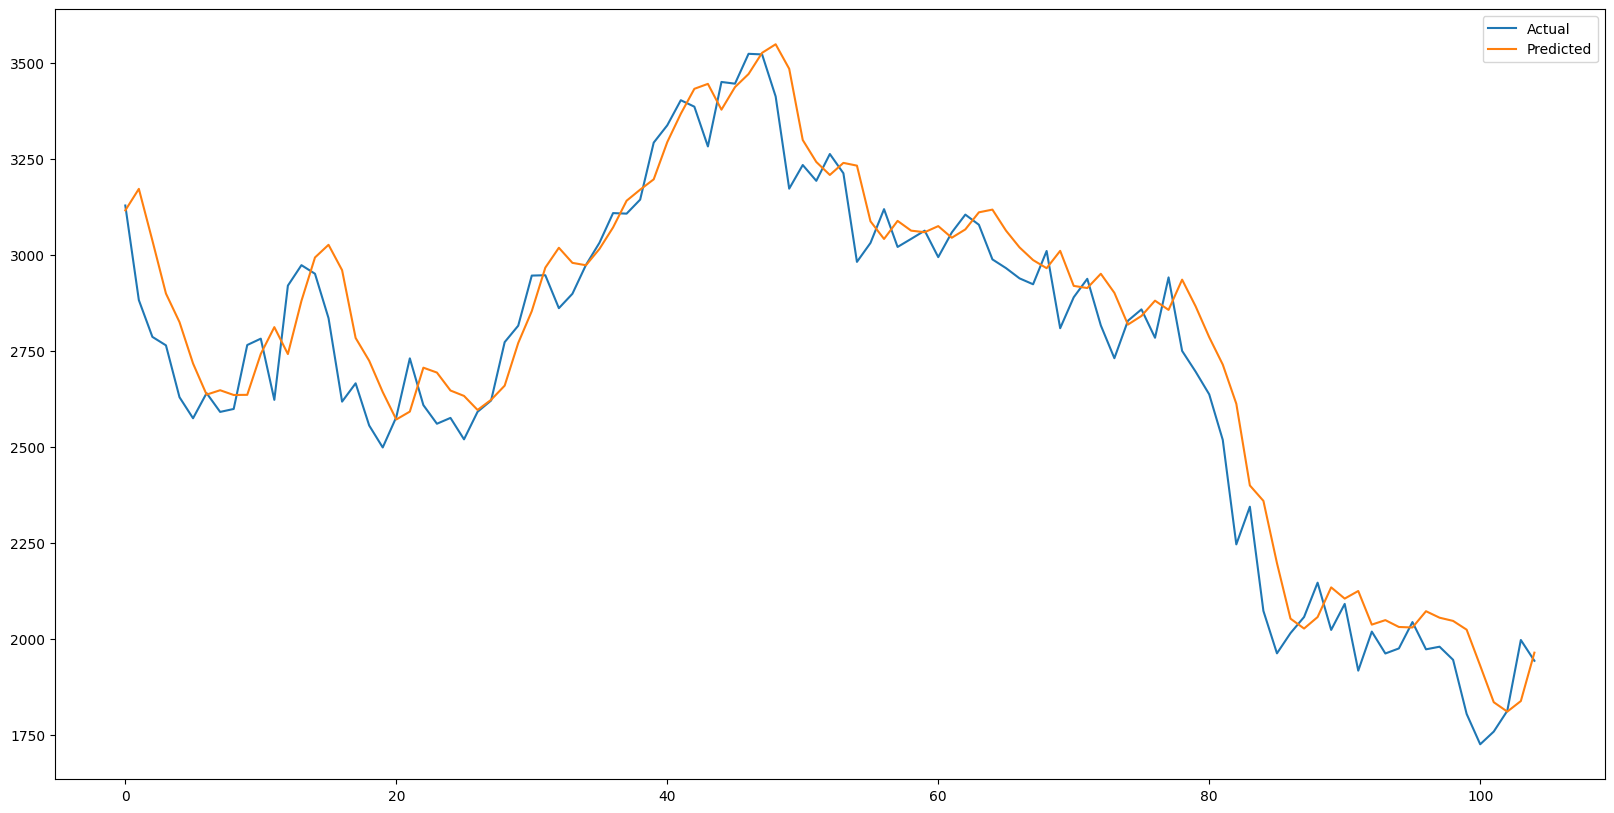

In [68]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_60_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_60_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [69]:
rmse_60 = np.sqrt(np.mean((test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted'])**2))
mae_60 = np.mean(np.abs(test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted']))
rmse_60, mae_60

(127.01095846439657, 97.21867327008933)

# Comparing the models 

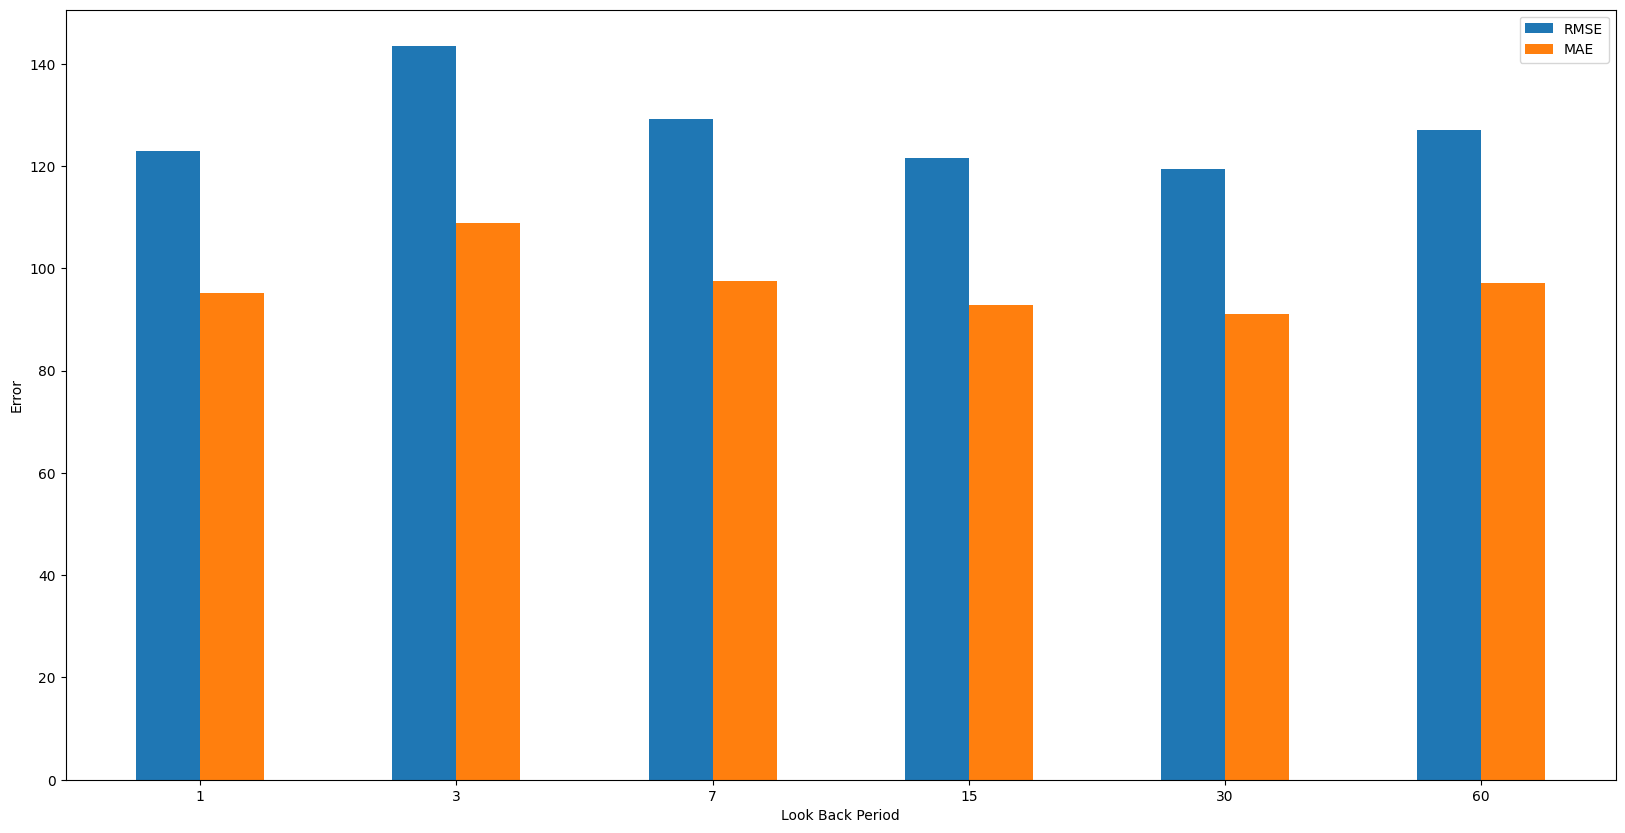

In [70]:
# Plotting in a bar chart, the RMSE and MAE for each look back period. The two metrics are plotted side by side for each look back period
plt.figure(figsize = (20, 10))
plt.bar(np.arange(6), [rmse, rmse_3, rmse_7, rmse_15, rmse_30, rmse_60], width = 0.25, label = 'RMSE')
plt.bar(np.arange(6) + 0.25, [mae, mae_3, mae_7, mae_15, mae_30, mae_60], width = 0.25, label = 'MAE')
plt.xticks(np.arange(6) + 0.125, ['1', '3', '7', '15', '30', '60'])
plt.xlabel('Look Back Period')
plt.ylabel('Error')
plt.legend()